## Deep Neural Network model with top n feature selection
*Summary:* In this notebook, we use a DNN model to predict `attack_cat` labels.

In [1]:
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', None)

train = pd.read_csv("../dataset/UNSW_NB15_training-set.csv")
test = pd.read_csv("../dataset/UNSW_NB15_testing-set.csv")

df = pd.concat([train, test]).reset_index(drop=True)
df = df.drop(columns=["id"])
df

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,0.000011,udp,-,INT,2,0,496,0,90909.090200,254,0,1.803636e+08,0.000000,0,0,0.011000,0.00000,0.000000,0.000000,0,0,0,0,0.00000,0.000000,0.000000,248,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,Normal,0
1,0.000008,udp,-,INT,2,0,1762,0,125000.000300,254,0,8.810000e+08,0.000000,0,0,0.008000,0.00000,0.000000,0.000000,0,0,0,0,0.00000,0.000000,0.000000,881,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,Normal,0
2,0.000005,udp,-,INT,2,0,1068,0,200000.005100,254,0,8.544000e+08,0.000000,0,0,0.005000,0.00000,0.000000,0.000000,0,0,0,0,0.00000,0.000000,0.000000,534,0,0,0,3,2,1,1,1,3,0,0,0,1,3,0,Normal,0
3,0.000006,udp,-,INT,2,0,900,0,166666.660800,254,0,6.000000e+08,0.000000,0,0,0.006000,0.00000,0.000000,0.000000,0,0,0,0,0.00000,0.000000,0.000000,450,0,0,0,3,2,2,2,1,3,0,0,0,2,3,0,Normal,0
4,0.000010,udp,-,INT,2,0,2126,0,100000.002500,254,0,8.504000e+08,0.000000,0,0,0.010000,0.00000,0.000000,0.000000,0,0,0,0,0.00000,0.000000,0.000000,1063,0,0,0,3,2,2,2,1,3,0,0,0,2,3,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257668,0.000009,udp,dns,INT,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,0,0,0.009000,0.00000,0.000000,0.000000,0,0,0,0,0.00000,0.000000,0.000000,57,0,0,0,24,2,24,24,13,24,0,0,0,24,24,0,Generic,1
257669,0.505762,tcp,-,FIN,10,8,620,354,33.612649,254,252,8.826286e+03,4903.492188,2,1,54.400111,66.98057,3721.068786,120.177727,255,3518776216,3453092386,255,0.09944,0.036895,0.062545,62,44,0,0,1,1,1,1,1,2,0,0,0,1,1,0,Shellcode,1
257670,0.000009,udp,dns,INT,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,0,0,0.009000,0.00000,0.000000,0.000000,0,0,0,0,0.00000,0.000000,0.000000,57,0,0,0,12,2,3,3,3,13,0,0,0,3,12,0,Generic,1
257671,0.000009,udp,dns,INT,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,0,0,0.009000,0.00000,0.000000,0.000000,0,0,0,0,0.00000,0.000000,0.000000,57,0,0,0,30,2,30,30,14,30,0,0,0,30,30,0,Generic,1


In [2]:
labels = df['attack_cat']
x_df = df.drop(columns=['label', 'attack_cat']).reset_index(drop=True)

### Preprocessing
The preprocessing includes the reduction of categorical features, one hot encoding the selected categorical features, and clamping the features that have a maximum of 10 times the median to the 95th quantile. We start with exploring the value counts of the categorical features.

In [3]:
cat_cols = x_df.select_dtypes(exclude=[np.number]).columns
x_df[cat_cols].describe()

,proto,service,state
count,257673,257673,257673
unique,133,13,11
top,tcp,-,FIN
freq,123041,141321,117164


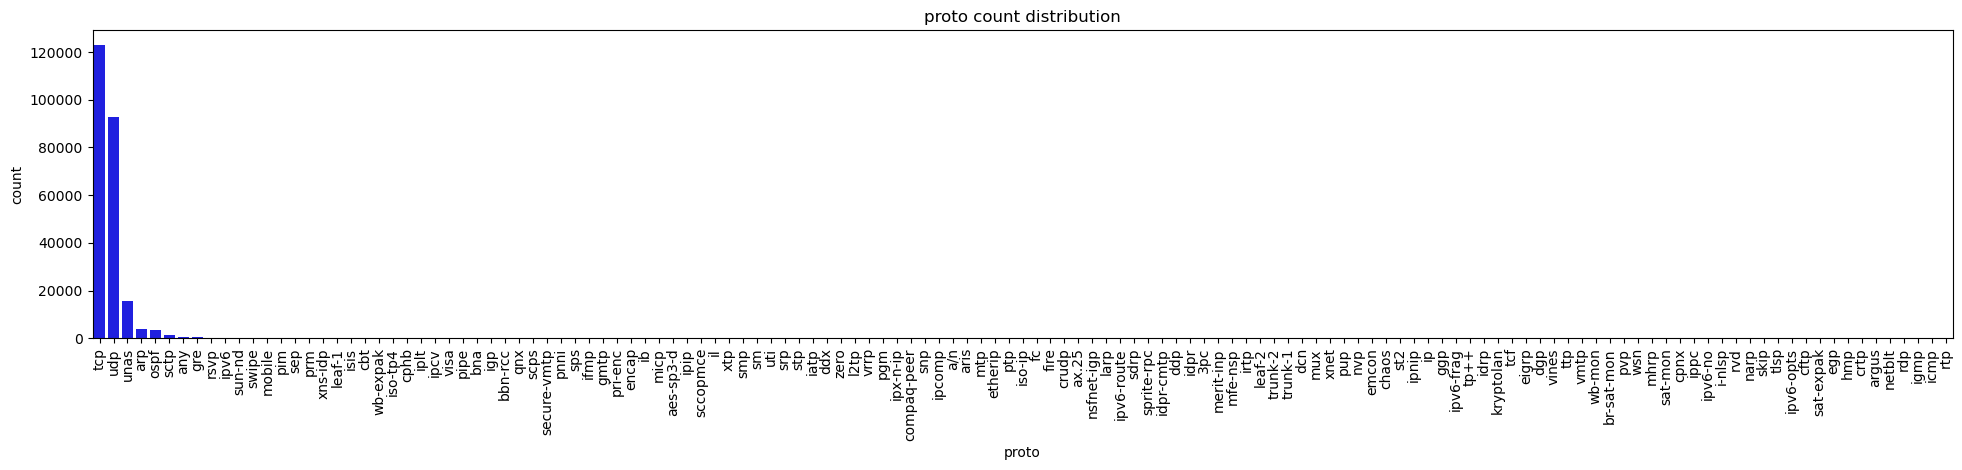

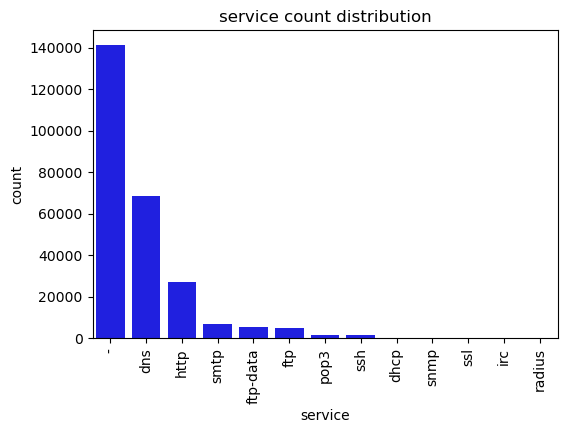

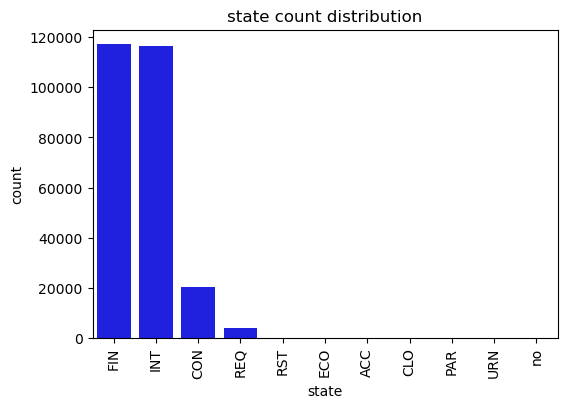

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_cat_col(col_name: str, size: tuple):
    fig, ax = plt.subplots(figsize=size)
    ax = sns.countplot(x=col_name, color='blue', data=df, order = df[col_name].value_counts().index)
    ax.set_title(f"{col_name} count distribution")
    plt.xticks(rotation=90)
    plt.show()

plot_cat_col('proto', (24, 4))
plot_cat_col('service', (6, 4))
plot_cat_col('state', (6, 4))

From the above plots, we can see that the categorical distribution is very skewed. The `proto` feature will cause the "curse of dimensionality" as most of the values that this feature can take are very rare. Moreover, the high dimensionality coupled with relatively sparse data describing the dimensions results in a model that is not accurate. In other words, the amount of training data describing the high dimensional features is sparse. 
To counteract this problem, we can reduce the dimensionality by keeping the top `n` counts and grouping the rest together as a single value.
For the categorical variables, we chose the following values for `n` based on the above count plots:
- `proto` keep top 5
- `service` keep top 6
- `state` keep top 4

In [6]:
from preprocessing import apply_clamping, reduce_top_n

n_map = {
    'proto': 5,
    'service': 6,
    'state': 4,
}

# reduce categories
x_df = reduce_top_n(x_df, n_map)

num_cols = x_df.select_dtypes(include=[np.number]).columns
cat_cols = x_df.select_dtypes(exclude=[np.number]).columns

# Concatenate numerical features and one-hot encoded reduced categorical features
x_df = pd.concat([x_df[num_cols], pd.get_dummies(x_df[cat_cols])], axis=1)

# apply clamping on features that are 10 times the median, so that the features are clamped to the 95th quantile
x_df = apply_clamping(x_df)

We standardize the numerical features to satisfy the assumption that many ML models have on the provided data.

In [7]:
from sklearn.preprocessing import StandardScaler

n_num_cols = len(num_cols)
sc = StandardScaler()
x_df.iloc[:, :n_num_cols] = sc.fit_transform(x_df.iloc[:, :n_num_cols])

x_df

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,proto_-,proto_arp,proto_ospf,proto_tcp,proto_udp,proto_unas,service_-,service_dns,service_ftp,service_ftp-data,service_http,service_smtp,state_-,state_CON,state_FIN,state_INT,state_REQ
0,-0.601388,-0.612483,-0.598367,-0.366656,-0.385036,0.121298,0.722026,-0.751628,1.686020,-0.357016,-0.667935,-0.492059,-0.600584,-0.616181,-0.616784,-0.360494,-0.955926,-0.740948,-0.740343,-0.937314,-0.495523,-0.439166,-0.489097,0.861266,-0.525620,-0.330846,-0.261031,-0.707283,0.680262,-0.678438,-0.562542,-0.536492,-0.585598,-0.110419,-0.110372,-0.330832,-0.759803,-0.677838,-0.120335,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0
1,-0.601392,-0.612483,-0.598367,0.029307,-0.385036,0.440638,0.722026,-0.751628,2.811737,-0.357016,-0.667935,-0.492059,-0.600632,-0.616181,-0.616784,-0.360494,-0.955926,-0.740948,-0.740343,-0.937314,-0.495523,-0.439166,-0.489097,3.550052,-0.525620,-0.330846,-0.261031,-0.707283,0.680262,-0.678438,-0.562542,-0.536492,-0.585598,-0.110419,-0.110372,-0.330832,-0.759803,-0.677838,-0.120335,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0
2,-0.601396,-0.612483,-0.598367,-0.187754,-0.385036,1.143184,0.722026,-0.751628,2.811737,-0.357016,-0.667935,-0.492059,-0.600681,-0.616181,-0.616784,-0.360494,-0.955926,-0.740948,-0.740343,-0.937314,-0.495523,-0.439166,-0.489097,2.833043,-0.525620,-0.330846,-0.261031,-0.607869,0.680262,-0.678438,-0.562542,-0.536492,-0.488829,-0.110419,-0.110372,-0.330832,-0.759803,-0.578989,-0.120335,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0
3,-0.601394,-0.612483,-0.598367,-0.240298,-0.385036,0.830941,0.722026,-0.751628,2.811737,-0.357016,-0.667935,-0.492059,-0.600665,-0.616181,-0.616784,-0.360494,-0.955926,-0.740948,-0.740343,-0.937314,-0.495523,-0.439166,-0.489097,2.253919,-0.525620,-0.330846,-0.261031,-0.607869,0.680262,-0.532805,-0.416867,-0.536492,-0.488829,-0.110419,-0.110372,-0.330832,-0.618650,-0.578989,-0.120335,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0
4,-0.601389,-0.612483,-0.598367,0.143154,-0.385036,0.206456,0.722026,-0.751628,2.811737,-0.357016,-0.667935,-0.492059,-0.600600,-0.616181,-0.616784,-0.360494,-0.955926,-0.740948,-0.740343,-0.937314,-0.495523,-0.439166,-0.489097,3.550052,-0.525620,-0.330846,-0.261031,-0.607869,0.680262,-0.532805,-0.416867,-0.536492,-0.488829,-0.110419,-0.110372,-0.330832,-0.618650,-0.578989,-0.120335,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257668,-0.601390,-0.612483,-0.598367,-0.486133,-0.385036,0.310537,0.722026,-0.751628,-0.005720,-0.357016,-0.667935,-0.492059,-0.600616,-0.616181,-0.616784,-0.360494,-0.955926,-0.740948,-0.740343,-0.937314,-0.495523,-0.439166,-0.489097,-0.455550,-0.525620,-0.330846,-0.261031,1.479825,0.680262,2.671135,2.787980,1.699319,1.543318,-0.110419,-0.110372,-0.330832,2.486722,1.496821,-0.120335,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0
257669,0.064875,-0.138029,-0.112667,-0.327873,-0.342698,-0.729958,0.722026,1.483170,-0.666489,-0.351982,-0.055424,-0.325637,0.278751,0.719074,0.687535,-0.175913,1.046159,1.880567,1.840328,1.066927,0.574782,0.245898,0.877393,-0.421079,-0.314053,-0.330846,-0.261031,-0.806697,-0.327500,-0.678438,-0.562542,-0.536492,-0.585598,-0.110419,-0.110372,-0.330832,-0.759803,-0.776686,-0.120335,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0
257670,-0.601390,-0.612483,-0.598367,-0.486133,-0.385036,0.310537,0.722026,-0.751628,-0.005720,-0.357016,-0.667935,-0.492059,-0.600616,-0.616181,-0.616784,-0.360494,-0.955926,-0.740948,-0.740343,-0.937314,-0.495523,-0.439166,-0.489097,-0.455550,-0.525620,-0.330846,-0.261031,0.286857,0.680262,-0.387171,

Split the dataset into train, test sets with a $\frac13$ proportion of the data as the test set.

In [33]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x_df, labels, test_size=.33, random_state=42)

(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

((172640, 56), (85033, 56), (172640,), (85033,))

As can be seen below, the attack categories are imbalanced. This can cause problems in the model because it learns a bias through the data. The result of which is that the model tends to predict the majority class more often.

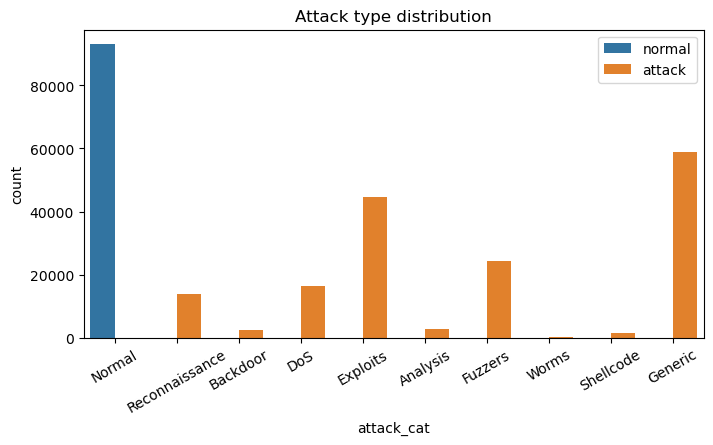

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(8,4))
ax = sns.countplot(x='attack_cat', hue='label', data=df)
ax.legend(loc="upper right", labels=('normal', 'attack'))
ax.set_title("Attack type distribution")
plt.xticks(rotation=30)
plt.show()

In [35]:
labels.value_counts()

Normal            93000
Generic           58871
Exploits          44525
Fuzzers           24246
DoS               16353
Reconnaissance    13987
Analysis           2677
Backdoor           2329
Shellcode          1511
Worms               174
Name: attack_cat, dtype: int64

We use SMOTE (Synthetic Minority Over-sampling Technique) to balance the training dataset.

In [36]:
from imblearn.over_sampling import SMOTE 

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

(X_res.shape, y_res.shape)

((623170, 56), (623170,))

In [118]:
# shuffle dataframe and split into X and y
train_set = pd.concat([X_res, y_res], axis=1)
train_set = train_set.sample(frac=1)

# reduce set to smaller set
train_set = train_set[:X_train.shape[0]]

X_train = train_set.iloc[:, :-1]
y_train = train_set.iloc[:, -1:]

(X_train.shape, y_train.shape)

((172640, 56), (172640, 1))

Split the training set further by using 10000 records as validation samples.

In [119]:
X_val = X_train.iloc[-10000:]
y_val = y_train.iloc[-10000:]

X_train = X_train.iloc[:-10000]
y_train = y_train.iloc[:-10000]

print(f"Training dataset:   {(X_train.shape, y_train.shape)}")
print(f"validation dataset: {(X_val.shape, y_val.shape)}")

Training dataset:   ((162640, 56), (162640, 1))
validation dataset: ((10000, 56), (10000, 1))


In [120]:
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)
y_val = pd.get_dummies(y_val)

### Model and training

In [156]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
!pip install livelossplot
from livelossplot import PlotLossesKeras

In [158]:
def create_model():
    model = keras.Sequential(
        [
            layers.Dense(30, activation='relu', input_dim=X_train.shape[1]),
            layers.Dense(30, activation='relu', use_bias=True),
            layers.Dense(30, activation='relu', use_bias=True),
            layers.Dense(30, activation='relu', use_bias=True),
            layers.Dense(30, activation='relu', use_bias=True),
            layers.Dense(30, activation='relu', use_bias=True),
            layers.Dense(30, activation='relu', use_bias=True),
            layers.Dense(30, activation='relu', use_bias=True),
            layers.Dense(30, activation='relu', use_bias=True),
            layers.Dense(30, activation='relu', use_bias=True),
            layers.Dense(30, activation='relu', use_bias=True),
            layers.Dense(10, activation='softmax', use_bias=True)
        ]
    )
    model.compile('adam', loss='categorical_crossentropy', metrics='accuracy')
    return model

model = create_model()
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_74 (Dense)            (None, 30)                1710      
                                                                 
 dense_75 (Dense)            (None, 30)                930       
                                                                 
 dense_76 (Dense)            (None, 30)                930       
                                                                 
 dense_77 (Dense)            (None, 30)                930       
                                                                 
 dense_78 (Dense)            (None, 30)                930       
                                                                 
 dense_79 (Dense)            (None, 30)                930       
                                                                 
 dense_80 (Dense)            (None, 30)              

In [159]:
import os

checkpoint_path = "../models/model_dnn_mc_topn.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

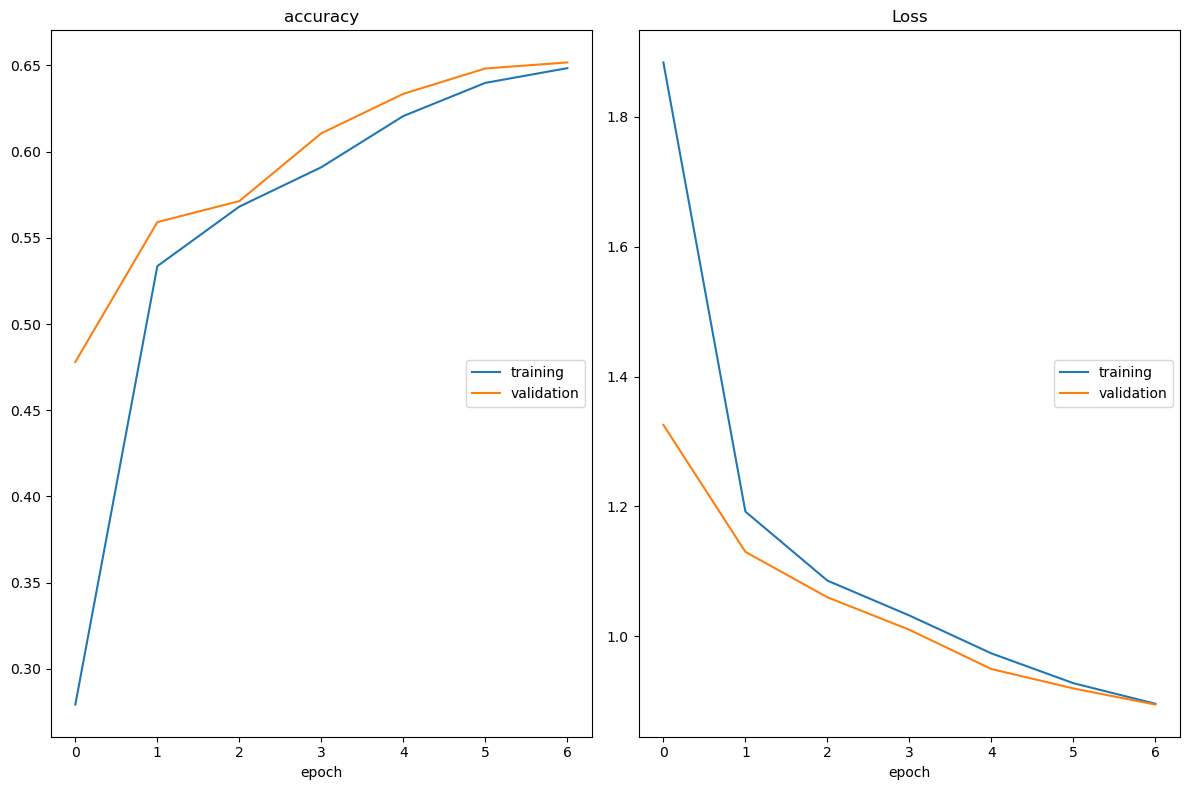

accuracy
	training         	 (min:    0.279, max:    0.648, cur:    0.648)
	validation       	 (min:    0.478, max:    0.652, cur:    0.652)
Loss
	training         	 (min:    0.896, max:    1.884, cur:    0.896)
	validation       	 (min:    0.894, max:    1.325, cur:    0.894)
82/82 - 28s - loss: 0.8957 - accuracy: 0.6484 - val_loss: 0.8944 - val_accuracy: 0.6517 - 28s/epoch - 341ms/step
Epoch 8/200


KeyboardInterrupt: 

In [160]:
EPOCHS = 200
BATCH_SIZE = 2000

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 save_freq=BATCH_SIZE)

history = model.fit(X_train,
                    y_train, 
                    validation_data=(X_val, y_val),
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    shuffle=True,
                    verbose=2,
                    callbacks=[PlotLossesKeras(), cp_callback])

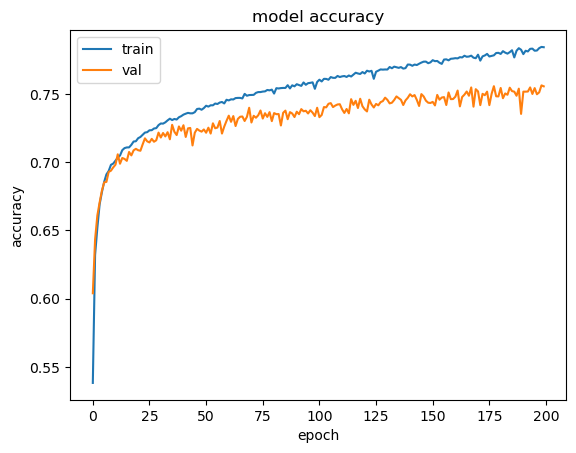

In [145]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

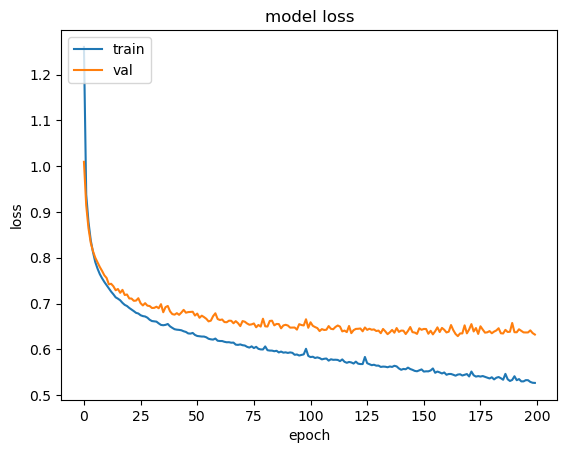

In [146]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [148]:
y_pred = model.predict(X_test)

2658/2658 [==============================] - 3s 939us/step


In [149]:
class estimator:
  _estimator_type = ''
  classes_=[]
  def __init__(self, model, classes):
    self.model = model
    self._estimator_type = 'classifier'
    self.classes_ = classes
  def predict(self, X):
    y_prob = self.model.predict(X)
    y_pred = y_prob.argmax(axis=1)
    return y_pred

classifier = estimator(model, sorted(list(labels.unique())))

In [150]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test.to_numpy().argmax(axis=1), y_pred.argmax(axis=1))
cm = np.around(cm / cm.astype('float').sum(axis=1, keepdims=True), decimals=3)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)

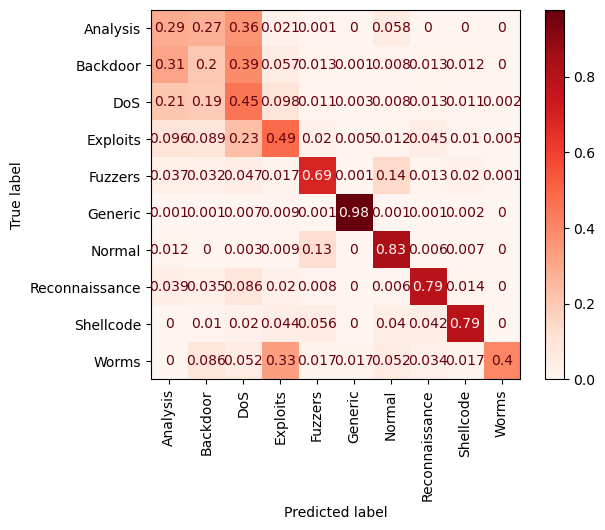

In [151]:
disp.plot(cmap=plt.cm.Reds, xticks_rotation=90)

In [152]:
from sklearn.metrics import accuracy_score

ys = y_test.to_numpy().argmax(axis=1)
ys_pred = y_pred.argmax(axis=1)

accuracy_score(ys, ys_pred)

0.754213070219797